In [234]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.othermod import betareg

pd.set_option('max_columns', None)
sns.set_theme(style="ticks")

In [235]:
team_year_by_year = pd.read_csv('result_all_teams.csv')

In [236]:
league_standings = pd.read_csv('standings_selected_feat.csv')

In [237]:
rosters_players_combined = pd.read_csv('rosters_players_combined.csv')

Feature engineering (Home Win Percentage)

In [238]:
league_standings

,SeasonID,TeamID,TeamName,OppPointsPG,HOME,PlayoffRank
0,1984,1610612738,Celtics,108.1,35-6,1
1,1984,1610612747,Lakers,110.9,36-5,1
2,1984,1610612743,Nuggets,117.6,34-7,2
3,1984,1610612749,Bucks,104.0,36-5,2
4,1984,1610612745,Rockets,109.5,29-12,3
...,...,...,...,...,...,...
1105,2022,1610612757,Trail Blazers,117.4,17-24,13
1106,2022,1610612745,Rockets,118.6,14-27,14
1107,2022,1610612766,Hornets,117.2,13-28,14
1108,2022,1610612759,Spurs,123.1,14-27,15


In [239]:
league_standings[['HOME_W', 'HOME_L']] = league_standings['HOME'].str.split('-', expand=True)

In [240]:
league_standings['HOME_W'] = league_standings['HOME_W'].astype(int)

In [241]:
league_standings['HOME_L'] = league_standings['HOME_L'].astype(int)

In [242]:
league_standings['HOME_WIN_PCT'] = league_standings['HOME_W']/(league_standings['HOME_W']+league_standings['HOME_L'])

In [243]:
league_standings = league_standings.drop(['HOME', 'HOME_W', 'HOME_L'], axis=1)

In [244]:
league_standings = league_standings.rename(columns={'SeasonID':'YEAR', 'TeamID':'TEAM_ID', 'OppPointsPG':'OPP_PPG'})

In [245]:
league_standings['PLAYOFF'] = np.where(league_standings['PlayoffRank']<=8, 1, 0)

In [246]:
league_standings = league_standings.drop(['PlayoffRank'], axis=1)

Merge Standings and All Teams

In [247]:
all_teams_data = team_year_by_year.merge(league_standings, on=['TEAM_ID', 'YEAR'], how='inner')

In [248]:
all_teams_data = all_teams_data.drop(['TeamName'], axis=1)

In [249]:
all_teams_data

,TEAM_ID,TEAM_NAME,YEAR,WIN_PCT,FG_PCT,REB,AST_TOV_RAT,PTS,OPP_PPG,HOME_WIN_PCT,PLAYOFF
0,1610612739,Cavaliers,1984,0.439,0.471,44.5,1.514793,108.6,111.3,0.487805,1
1,1610612739,Cavaliers,1985,0.354,0.480,43.2,1.465116,107.8,110.6,0.390244,0
2,1610612739,Cavaliers,1986,0.378,0.470,44.8,1.182741,104.4,108.2,0.609756,0
3,1610612739,Cavaliers,1987,0.512,0.490,40.3,1.440000,104.5,103.7,0.756098,1
4,1610612739,Cavaliers,1988,0.695,0.502,42.8,1.714286,108.8,101.2,0.902439,1
...,...,...,...,...,...,...,...,...,...,...,...
1105,1610612755,76ers,2018,0.622,0.471,47.8,1.805369,115.2,112.5,0.756098,1
1106,1610612755,76ers,2019,0.589,0.468,45.4,1.816901,110.7,108.4,0.885714,1
1107,1610612755,76ers,2020,0.681,0.476,45.1,1.645833,113.6,108.1,0.805556,1
1108,1610612755,76ers,2021,0.622,0.466,42.3,1.896000,109.9,107.3,0.585366,1


In [250]:
rosters_players_selected = rosters_players_combined.drop(['LeagueID', 'NICKNAME', 'PLAYER_SLUG', 'NUM', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'AGE', 'EXP', 'SCHOOL', 'HOW_ACQUIRED', 'LEAGUE_ID', 'PLAYER_AGE'], axis=1)

In [251]:
rosters_players_selected['PPG'] = rosters_players_selected['PTS']/rosters_players_selected['GP']  

In [252]:
rosters_players_selected['MINPG'] = rosters_players_selected['MIN']/rosters_players_selected['GP']  

In [253]:
rosters_players_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15789 entries, 0 to 15788
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TEAM_ID            15789 non-null  int64  
 1   SEASON_ID          15789 non-null  int64  
 2   PLAYER             15789 non-null  object 
 3   POSITION           15785 non-null  object 
 4   PLAYER_ID          15789 non-null  int64  
 5   TEAM_ABBREVIATION  15789 non-null  object 
 6   GP                 15789 non-null  int64  
 7   GS                 15789 non-null  float64
 8   MIN                15789 non-null  float64
 9   FGM                15789 non-null  int64  
 10  FGA                15789 non-null  int64  
 11  FG_PCT             15788 non-null  float64
 12  FG3M               15789 non-null  float64
 13  FG3A               15789 non-null  float64
 14  FG3_PCT            15736 non-null  float64
 15  FTM                15789 non-null  int64  
 16  FTA                157

Top3 Scorers Extraction

In [254]:
rosters_players_top3 = rosters_players_selected.sort_values('PTS', ascending=False).groupby(["TEAM_ID", "SEASON_ID"]).head(3)

In [255]:
rosters_players_top3 = rosters_players_top3.sort_values(['TEAM_ID','SEASON_ID']).reset_index(drop=True)

In [256]:
rosters_players_top3

,TEAM_ID,SEASON_ID,PLAYER,POSITION,PLAYER_ID,TEAM_ABBREVIATION,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PPG,MINPG
0,1610612737,1984,Dominique Wilkins,F,1122,ATL,81,81.0,3023.0,853,1891,0.451,25.0,81.0,0.309,486,603,0.806,226.0,331.0,557,200,135.0,54.0,225.0,170,2217,27.370370,37.320988
1,1610612737,1984,Eddie Johnson,G,77144,ATL,73,66.0,2367.0,453,946,0.479,22.0,72.0,0.306,265,332,0.798,38.0,154.0,192,566,43.0,7.0,244.0,184,1193,16.342466,32.424658
2,1610612737,1984,Doc Rivers,G,470,ATL,69,58.0,2126.0,334,701,0.476,15.0,36.0,0.417,291,378,0.770,66.0,148.0,214,410,163.0,53.0,176.0,250,974,14.115942,30.811594
3,1610612737,1985,Dominique Wilkins,F,1122,ATL,78,78.0,3049.0,888,1897,0.468,13.0,70.0,0.186,577,705,0.818,261.0,357.0,618,206,138.0,49.0,251.0,170,2366,30.333333,39.089744
4,1610612737,1985,Randy Wittman,G,1456,ATL,81,79.0,2760.0,467,881,0.530,5.0,16.0,0.313,104,135,0.770,51.0,119.0,170,306,81.0,14.0,114.0,118,1043,12.876543,34.074074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,1610612766,2021,LaMelo Ball,G,1630163,CHA,75,75.0,2422.0,538,1254,0.429,220.0,565.0,0.389,212,243,0.872,108.0,393.0,501,571,119.0,30.0,245.0,237,1508,20.106667,32.293333
3326,1610612766,2021,Terry Rozier,G,1626179,CHA,73,73.0,2458.0,518,1167,0.444,222.0,593.0,0.374,150,176,0.852,56.0,259.0,315,326,93.0,25.0,96.0,119,1408,19.287671,33.671233
3327,1610612766,2022,Terry Rozier,G,1626179,CHA,63,63.0,2221.0,493,1188,0.415,165.0,505.0,0.327,178,220,0.809,51.0,208.0,259,319,74.0,16.0,134.0,119,1329,21.095238,35.253968
3328,1610612766,2022,P.J. Washington,F,1629023,CHA,73,73.0,2380.0,434,978,0.444,149.0,428.0,0.348,127,174,0.730,73.0,285.0,358,175,66.0,79.0,110.0,193,1144,15.671233,32.602740


In [257]:
rosters_players_top3_min = rosters_players_top3[['TEAM_ID', 'SEASON_ID', 'PPG']].groupby(by=['TEAM_ID', 'SEASON_ID']).min().reset_index()

In [258]:
rosters_players_top3_mean = rosters_players_top3[['TEAM_ID', 'SEASON_ID', 'PPG']].groupby(by=['TEAM_ID', 'SEASON_ID']).mean().reset_index()

In [259]:
rosters_players_top3_min

,TEAM_ID,SEASON_ID,PPG
0,1610612737,1984,14.115942
1,1610612737,1985,12.317073
2,1610612737,1986,12.841463
3,1610612737,1987,11.613333
4,1610612737,1988,15.804878
...,...,...,...
1105,1610612766,2018,10.080000
1106,1610612766,2019,12.969231
1107,1610612766,2020,12.727273
1108,1610612766,2021,19.287671


In [260]:
rosters_players_top3_min['TOP3_P14'] = np.where(rosters_players_top3_min['PPG']>=10, 1, 0)

In [261]:
rosters_players_top3_min = rosters_players_top3_min.rename(columns={'SEASON_ID':'YEAR'})

In [262]:
rosters_players_top3_min = rosters_players_top3_min.drop(['PPG'], axis=1)

In [263]:
rosters_players_top3_min

,TEAM_ID,YEAR,TOP3_P14
0,1610612737,1984,1
1,1610612737,1985,1
2,1610612737,1986,1
3,1610612737,1987,1
4,1610612737,1988,1
...,...,...,...
1105,1610612766,2018,1
1106,1610612766,2019,1
1107,1610612766,2020,1
1108,1610612766,2021,1


In [264]:
rosters_players_top3_mean = rosters_players_top3_mean.rename(columns={'PPG':'TOP3_PPG', 'SEASON_ID':'YEAR'})

In [265]:
rosters_players_top3_mean

,TEAM_ID,YEAR,TOP3_PPG
0,1610612737,1984,19.276259
1,1610612737,1985,18.508983
2,1610612737,1986,19.326068
3,1610612737,1987,18.839701
4,1610612737,1988,20.750752
...,...,...,...
1105,1610612766,2018,17.001762
1106,1610612766,2019,16.381278
1107,1610612766,2020,17.577404
1108,1610612766,2021,19.852279


Extracting Off Bench Players

In [266]:
rosters_players_starters = rosters_players_selected.sort_values('MIN', ascending=False).groupby(["TEAM_ID", "SEASON_ID"]).head(5)
rosters_players_starters = rosters_players_starters.sort_values(['TEAM_ID','SEASON_ID'])

In [267]:
starters_idx = list(rosters_players_starters.index.values)
starters_idx

[8891,
 8884,
 8888,
 8885,
 8893,
 8906,
 8909,
 8908,
 8902,
 8904,
 8919,
 8921,
 8916,
 8923,
 8914,
 8934,
 8929,
 8936,
 8928,
 8935,
 8950,
 8944,
 8947,
 8946,
 8943,
 8963,
 8956,
 8965,
 8962,
 8954,
 8977,
 8974,
 8978,
 8976,
 8969,
 8994,
 8980,
 8989,
 8988,
 8983,
 9008,
 8996,
 9007,
 8995,
 9003,
 9011,
 9022,
 9009,
 9013,
 9018,
 9026,
 9024,
 9032,
 9034,
 9027,
 9048,
 9043,
 9042,
 9038,
 9040,
 9058,
 9054,
 9063,
 9053,
 9059,
 9075,
 9068,
 9069,
 9072,
 9071,
 9086,
 9079,
 9084,
 9078,
 9085,
 9098,
 9097,
 9094,
 9092,
 9095,
 9108,
 9109,
 9110,
 9105,
 9107,
 9113,
 9121,
 9112,
 9117,
 9111,
 9125,
 9134,
 9131,
 9135,
 9132,
 9146,
 9138,
 9147,
 9144,
 9140,
 9154,
 9153,
 9155,
 9157,
 9159,
 9166,
 9167,
 9168,
 9175,
 9165,
 9181,
 9179,
 9187,
 9188,
 9178,
 9194,
 9196,
 9201,
 9199,
 9193,
 9206,
 9211,
 9209,
 9213,
 9215,
 9222,
 9223,
 9227,
 9228,
 9226,
 9240,
 9236,
 9234,
 9238,
 9242,
 9250,
 9247,
 9249,
 9256,
 9254,
 9269,
 9265,
 9262,

In [268]:
off_the_bench = rosters_players_selected.drop(index=starters_idx)

In [269]:
off_the_bench

,TEAM_ID,SEASON_ID,PLAYER,POSITION,PLAYER_ID,TEAM_ABBREVIATION,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PPG,MINPG
2,1610612738,1984,Quinn Buckner,G,76296,BOS,75,6.0,858.0,74,193,0.383,0.0,1.0,0.000,32,50,0.640,26.0,61.0,87,148,63.0,2.0,67.0,142,180,2.400000,11.440000
3,1610612738,1984,Rick Carlisle,G,76342,BOS,38,0.0,179.0,26,67,0.388,0.0,2.0,0.000,15,17,0.882,8.0,13.0,21,25,3.0,0.0,19.0,21,67,1.763158,4.710526
4,1610612738,1984,M.L. Carr,F,76351,BOS,47,0.0,397.0,62,149,0.416,9.0,23.0,0.391,17,17,1.000,21.0,22.0,43,24,21.0,6.0,24.0,44,150,3.191489,8.446809
5,1610612738,1984,Carlos Clark,G,76398,BOS,62,3.0,562.0,64,152,0.421,0.0,5.0,0.000,41,53,0.774,29.0,40.0,69,48,35.0,2.0,42.0,66,169,2.725806,9.064516
7,1610612738,1984,Greg Kite,C,1123,BOS,55,4.0,424.0,33,88,0.375,0.0,0.0,0.000,22,32,0.688,38.0,51.0,89,17,3.0,10.0,29.0,84,88,1.600000,7.709091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15782,1610612740,2022,Kira Lewis Jr.,G,1630184,NOP,25,0.0,235.0,40,88,0.455,15.0,34.0,0.441,19,22,0.864,5.0,28.0,33,23,10.0,2.0,10.0,24,114,4.560000,9.400000
15783,1610612740,2022,Brandon Ingram,F,1627742,NOP,45,45.0,1538.0,404,835,0.484,64.0,164.0,0.390,240,272,0.882,23.0,223.0,246,262,32.0,19.0,148.0,116,1112,24.711111,34.177778
15784,1610612740,2022,Jose Alvarado,G,1630631,NOP,61,10.0,1310.0,201,489,0.411,83.0,247.0,0.336,65,80,0.813,28.0,113.0,141,186,67.0,10.0,81.0,125,550,9.016393,21.475410
15786,1610612740,2022,Larry Nance Jr.,F-C,1626204,NOP,65,1.0,1381.0,186,305,0.610,14.0,42.0,0.333,55,79,0.696,106.0,248.0,354,119,56.0,37.0,42.0,133,441,6.784615,21.246154


In [270]:
off_the_bench_sum = off_the_bench[['TEAM_ID', 'SEASON_ID', 'PTS']].groupby(by=['TEAM_ID', 'SEASON_ID']).sum().reset_index()

In [271]:
off_the_bench_sum['OFF_BENCH_PPG'] = off_the_bench_sum['PTS']/82

In [272]:
off_the_bench_sum.describe()

,TEAM_ID,SEASON_ID,PTS,OFF_BENCH_PPG
count,1.110000e+03,1110.000000,1110.000000,1110.000000
mean,1.610613e+09,2003.727928,2464.561261,30.055625
std,8.571716e+00,11.042987,648.376567,7.907031
min,1.610613e+09,1984.000000,565.000000,6.890244
25%,1.610613e+09,1994.000000,2035.500000,24.823171
50%,1.610613e+09,2004.000000,2502.000000,30.512195
75%,1.610613e+09,2013.000000,2929.500000,35.725610
max,1.610613e+09,2022.000000,4083.000000,49.792683


In [273]:
off_the_bench_sum['BENCH_P30'] = np.where(off_the_bench_sum['OFF_BENCH_PPG']>=bench_value, 1, 0)

In [274]:
off_the_bench_sum = off_the_bench_sum.rename(columns={'SEASON_ID':'YEAR'})

In [275]:
off_the_bench_sum = off_the_bench_sum.drop('PTS', axis=1)

In [276]:
off_the_bench_sum

,TEAM_ID,YEAR,OFF_BENCH_PPG,BENCH_P30
0,1610612737,1984,34.963415,1
1,1610612737,1985,40.426829,1
2,1610612737,1986,34.280488,1
3,1610612737,1987,33.524390,1
4,1610612737,1988,28.097561,0
...,...,...,...,...
1105,1610612766,2018,45.353659,1
1106,1610612766,2019,23.024390,0
1107,1610612766,2020,38.182927,1
1108,1610612766,2021,37.451220,1


In [277]:
all_teams_full = all_teams_data.copy()

In [278]:
all_teams_full

,TEAM_ID,TEAM_NAME,YEAR,WIN_PCT,FG_PCT,REB,AST_TOV_RAT,PTS,OPP_PPG,HOME_WIN_PCT,PLAYOFF
0,1610612739,Cavaliers,1984,0.439,0.471,44.5,1.514793,108.6,111.3,0.487805,1
1,1610612739,Cavaliers,1985,0.354,0.480,43.2,1.465116,107.8,110.6,0.390244,0
2,1610612739,Cavaliers,1986,0.378,0.470,44.8,1.182741,104.4,108.2,0.609756,0
3,1610612739,Cavaliers,1987,0.512,0.490,40.3,1.440000,104.5,103.7,0.756098,1
4,1610612739,Cavaliers,1988,0.695,0.502,42.8,1.714286,108.8,101.2,0.902439,1
...,...,...,...,...,...,...,...,...,...,...,...
1105,1610612755,76ers,2018,0.622,0.471,47.8,1.805369,115.2,112.5,0.756098,1
1106,1610612755,76ers,2019,0.589,0.468,45.4,1.816901,110.7,108.4,0.885714,1
1107,1610612755,76ers,2020,0.681,0.476,45.1,1.645833,113.6,108.1,0.805556,1
1108,1610612755,76ers,2021,0.622,0.466,42.3,1.896000,109.9,107.3,0.585366,1


In [279]:
all_teams_full = all_teams_full.merge(rosters_players_top3_mean, how='inner', on=['TEAM_ID', 'YEAR'])

In [280]:
all_teams_full = all_teams_full.merge(rosters_players_top3_min, how='inner', on=['TEAM_ID', 'YEAR'])

In [281]:
all_teams_full = all_teams_full.merge(off_the_bench_sum, how='inner', on=['TEAM_ID', 'YEAR'])

In [282]:
all_teams_full

,TEAM_ID,TEAM_NAME,YEAR,WIN_PCT,FG_PCT,REB,AST_TOV_RAT,PTS,OPP_PPG,HOME_WIN_PCT,PLAYOFF,TOP3_PPG,TOP3_P14,OFF_BENCH_PPG,BENCH_P30
0,1610612739,Cavaliers,1984,0.439,0.471,44.5,1.514793,108.6,111.3,0.487805,1,18.032740,1,34.951220,1
1,1610612739,Cavaliers,1985,0.354,0.480,43.2,1.465116,107.8,110.6,0.390244,0,18.894844,1,28.853659,0
2,1610612739,Cavaliers,1986,0.378,0.470,44.8,1.182741,104.4,108.2,0.609756,0,17.705386,1,31.109756,1
3,1610612739,Cavaliers,1987,0.512,0.490,40.3,1.440000,104.5,103.7,0.756098,1,16.714243,1,27.926829,0
4,1610612739,Cavaliers,1988,0.695,0.502,42.8,1.714286,108.8,101.2,0.902439,1,18.791115,1,28.060976,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,1610612755,76ers,2018,0.622,0.471,47.8,1.805369,115.2,112.5,0.756098,1,20.830769,1,23.475610,0
1106,1610612755,76ers,2019,0.589,0.468,45.4,1.816901,110.7,108.4,0.885714,1,19.672070,1,37.109756,1
1107,1610612755,76ers,2020,0.681,0.476,45.1,1.645833,113.6,108.1,0.805556,1,20.753404,1,38.341463,1
1108,1610612755,76ers,2021,0.622,0.466,42.3,1.896000,109.9,107.3,0.585366,1,21.757569,1,28.048780,0


##Feature Engineering Ends Here

In [283]:
new_features_matrix = all_teams_full[['WIN_PCT', 'TOP3_PPG', 'TOP3_P14', 'OFF_BENCH_PPG', 'BENCH_P30']]

In [284]:
new_features_matrix

,WIN_PCT,TOP3_PPG,TOP3_P14,OFF_BENCH_PPG,BENCH_P30
0,0.439,18.032740,1,34.951220,1
1,0.354,18.894844,1,28.853659,0
2,0.378,17.705386,1,31.109756,1
3,0.512,16.714243,1,27.926829,0
4,0.695,18.791115,1,28.060976,0
...,...,...,...,...,...
1105,0.622,20.830769,1,23.475610,0
1106,0.589,19.672070,1,37.109756,1
1107,0.681,20.753404,1,38.341463,1
1108,0.622,21.757569,1,28.048780,0


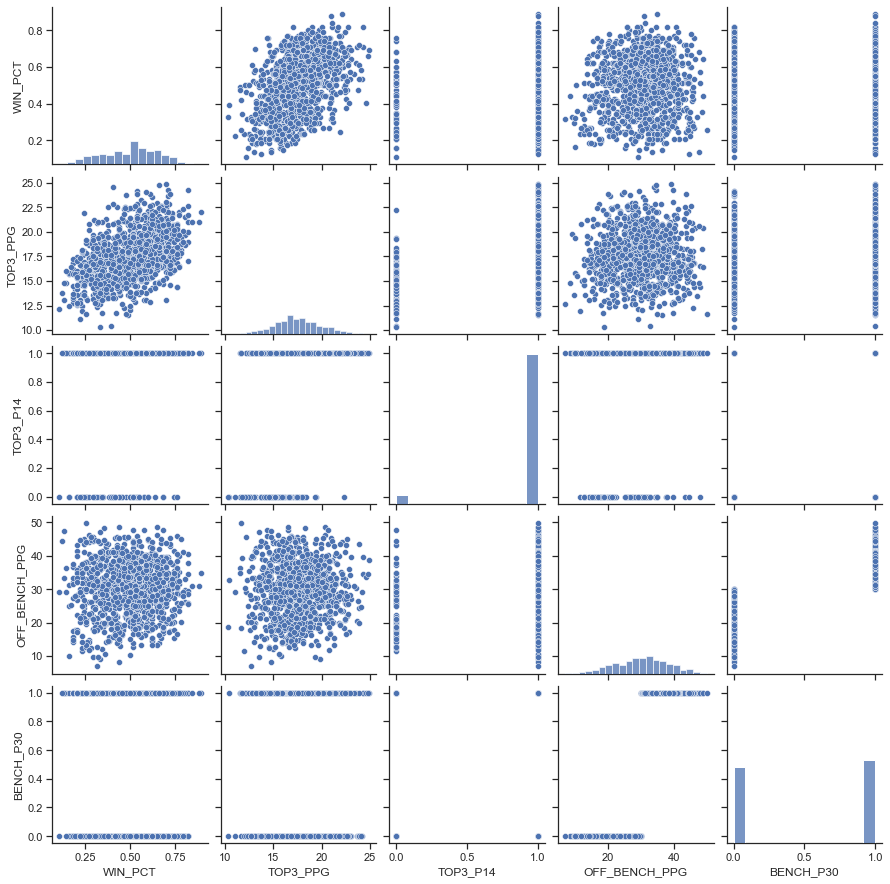

In [285]:
sns.pairplot(new_features_matrix)

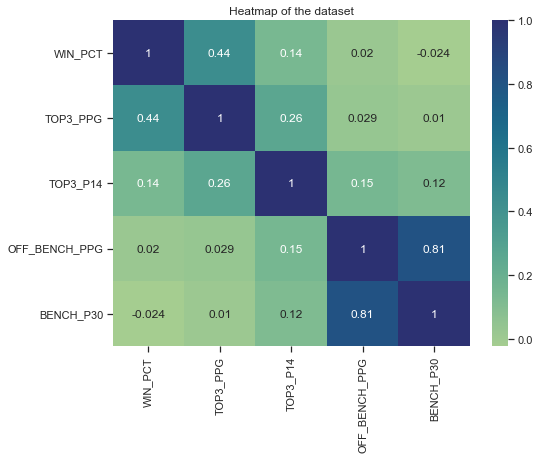

In [286]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    new_features_matrix.corr(), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

In [287]:
test_model_new_features = all_teams_full[['WIN_PCT', 'FG_PCT','REB','AST_TOV_RAT','OPP_PPG', 'TOP3_P14']]

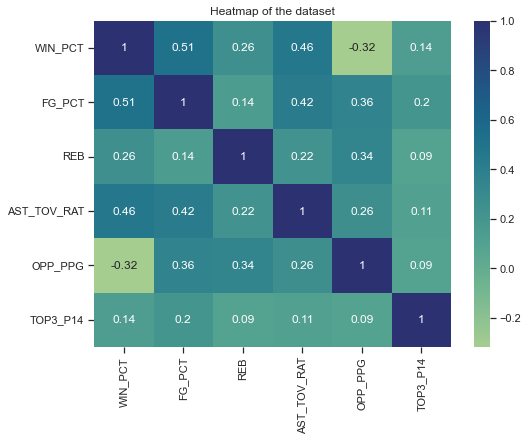

In [288]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    test_model_new_features.corr(), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

In [289]:
data_X = test_model_new_features[['FG_PCT','REB','AST_TOV_RAT','OPP_PPG', 'TOP3_P14']]
data_Y = test_model_new_features['WIN_PCT']
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, 
                                                    test_size = 0.3, random_state = 42)

In [290]:
# Write out OLS formula as a string
ols_formula = "WIN_PCT ~ FG_PCT + AST_TOV_RAT + REB + OPP_PPG + C(TOP3_P14)"

# Create OLS dataframe
ols_data = pd.concat([X_train, y_train], axis = 1)

# Create OLS object and fit the model
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()

# Get model results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                WIN_PCT   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     518.2
Date:                Fri, 02 Feb 2024   Prob (F-statistic):          1.13e-243
Time:                        14:55:33   Log-Likelihood:                 920.73
No. Observations:                 777   AIC:                            -1829.
Df Residuals:                     771   BIC:                            -1802.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.4856      0.077    -19.193      0.000      -1.638      -1.334
C(TOP3_P14)[T.1]     0.0161      0.011      1.412      0.158      -0.006       0.039
FG_PCT               4.5166      0.156     28.913      0.000       4.210       4.823
AST_TOV_RAT          0.2405      0.014     16.675      0.000       0.212       0.269
REB                  0.0265      0.001     19.907      0.000       0.024       0.029
OPP_PPG             -0.0157      0.000    -38.599      0.000      -0.017      -0.015
==============================================================================
Omnibus:                        9.322   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.285
Skew:                           0.253   Prob(JB):                      0.00963
Kurtosis:                       3.177   Cond. No.                     6.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""